In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score,train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

from patsy import dmatrix

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df =  pd.read_csv('/content/drive/MyDrive/An introduction to statistical analysis/data/Wage.csv')
df.head()
df = df.iloc[:,1:]
df.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [ ]:
X = df['age']
y = df['wage']

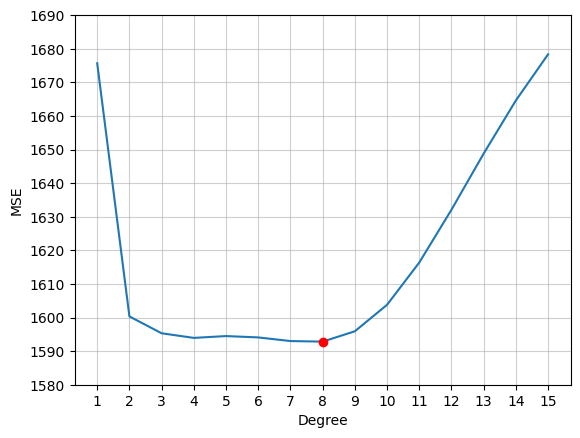

In [ ]:
scores = {}
degrees = 15
for i in range(1, degrees + 1):
    poly = PolynomialFeatures(i, include_bias = False)
    X_transf = poly.fit_transform(X.to_frame())
    lr = LinearRegression()
    scores[i] = (-np.mean(cross_val_score(lr, X_transf, y, scoring = 'neg_mean_squared_error', cv = 10)))

min_degree = min(scores, key=scores.get)
min_score = scores[min_degree]

plt.plot(list(range(1, degrees + 1)), list(scores.values()))
plt.plot(min_degree, min_score,  color = 'red', marker = 'o')
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.yticks(ticks = range(1580, 1700, 10))
plt.xticks(ticks=range(1, degrees + 1))
plt.grid(alpha=0.6)
plt.show()

The MSE trend is present again, the MSE starts to get lower and lower but then it starts to learn the noise more and more and it starts to increase forming this U shape.

In [ ]:
#Applying and ANOVA TEST

poly = PolynomialFeatures(5)
X = poly.fit_transform(df['age'].to_frame())
X = pd.DataFrame(X)
columnas = ['Constant'] + [f'X_{i}' for i in range(1, 6)]
X.columns = columnas
#X.head()

fit_1 = sm.OLS(y, X.iloc[:,:2]).fit()
fit_2 = sm.OLS(y, X.iloc[:,:3]).fit()
fit_3 = sm.OLS(y, X.iloc[:,:4]).fit()
fit_4 = sm.OLS(y, X.iloc[:,:5]).fit()
fit_5 = sm.OLS(y, X.iloc[:,:]).fit()
table = sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5)
print(table)

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


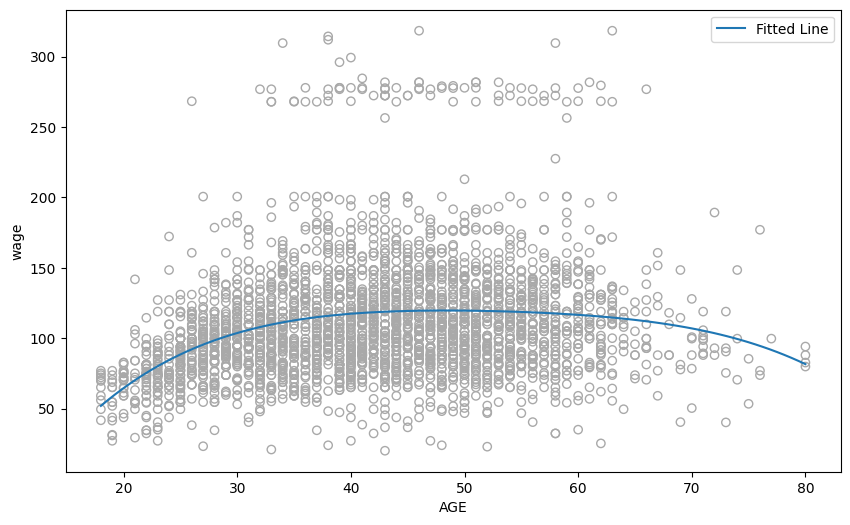

In [ ]:
poly = PolynomialFeatures(4)
X = poly.fit_transform(df['age'].to_frame())
y = df['wage']
model = LinearRegression()
model.fit(X,y)

test_ages = np.linspace(df['age'].min(),df['age'].max(),100)

X_test = poly.transform(test_ages.reshape(-1,1))
pred = model.predict(X_test)

pred = model.predict(X_test)
plt.figure(figsize = (10,6))
plt.scatter(df['age'],df['wage'],facecolors='none', edgecolors='darkgray')
plt.plot(test_ages,pred,label = 'Fitted Line')
plt.xlabel('AGE')
plt.ylabel('wage')
plt.legend()

# Step Function

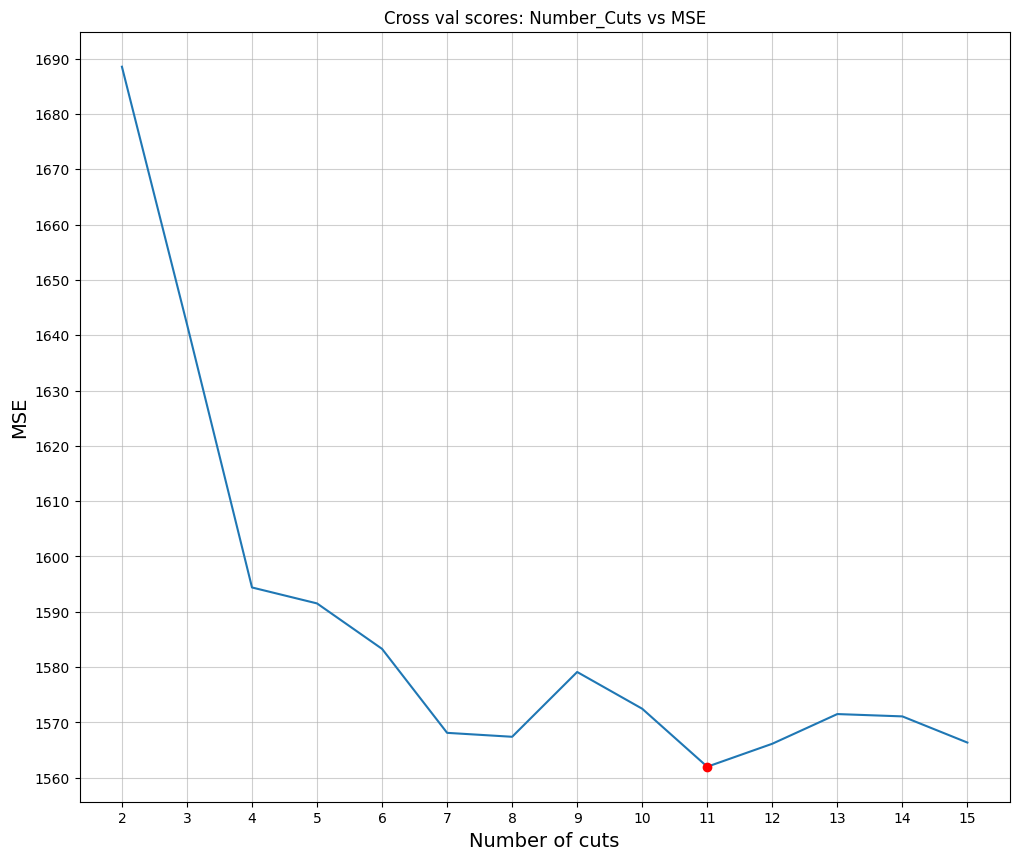

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['age'], df['wage'], test_size = 0.25, random_state = 2025)


scores = {}
n_cuts = 15
for n in range(2, n_cuts + 1):
    mse_scores = []
    kf = KFold(n_splits = 10, shuffle = True, random_state = 2025)

    for train_idx, test_idx in kf.split(X_train):
        X_val, X_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_val, y_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

        X_cut_val, bins = pd.cut(X_val.squeeze(), bins = n, retbins=True, labels = False)
        X_cut_test = np.digitize(X_test.squeeze(), bins[:-1]) - 1

        X_dummies_val = pd.get_dummies(X_cut_val, prefix='bin')
        X_dummies_test = pd.get_dummies(X_cut_test, prefix='bin')

        X_dummies_val, X_dummies_test = X_dummies_val.align(X_dummies_test, join='left', axis = 1, fill_value = 0)

        model = sm.OLS(y_val, X_dummies_val).fit()
        model_preds = model.predict(X_dummies_test)

        mse_scores.append(mean_squared_error(y_test, model_preds))

    scores[n] = np.mean(mse_scores)

min_cut = min(scores, key = scores.get)
min_score = scores[min_cut]


plt.figure(figsize = (12,10))
plt.plot(list(range(2, n_cuts + 1)), list(scores.values()))
plt.plot(min_cut, min_score, marker = 'o', color = 'red')
plt.title('Cross val scores: Number_Cuts vs MSE')
plt.xlabel('Number of cuts', fontsize = 14)
plt.ylabel('MSE', fontsize = 14)
plt.yticks(ticks = range(1560, 1700, 10))
plt.grid(alpha = 0.6)
plt.xticks(ticks =list(range(2, n_cuts + 1)))
plt.show()








The best number of points for the variable age suggested by KFolds with 10 splits is 11 cuts.


#Binning with the best result.

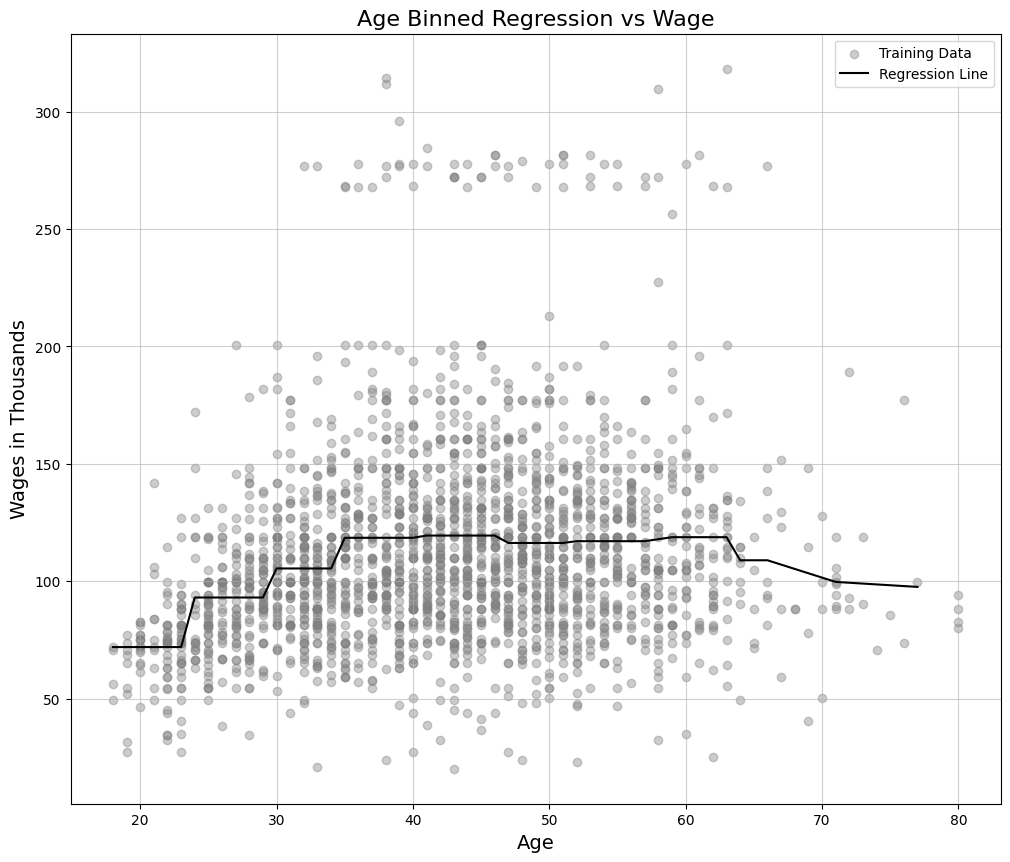

In [ ]:
X_train = pd.DataFrame(X_train, columns=['age'])
X_test = pd.DataFrame(X_test, columns=['age'])

X_train_cut, bins = pd.cut(X_train['age'], bins=11, retbins=True, labels=False)
X_train_cut = pd.Series(X_train_cut, index=X_train.index)

X_test_cut = np.digitize(X_test['age'], bins[:-1]) - 1
X_test_cut = pd.Series(X_test_cut, index=X_test.index)

X_train_dummies = pd.get_dummies(X_train_cut, prefix='bin').astype(int)
X_test_dummies = pd.get_dummies(X_test_cut, prefix='bin').astype(int)

# Verificar si hay valores faltantes en X_train_dummies
#print(f'X_train_dummies nulls : {X_train_dummies.isna().sum()}')
#print("Valores únicos en X_train_cut:", np.unique(X_train_cut))
#print("Valores únicos en X_test_cut:", np.unique(X_test_cut))

model = sm.OLS(y_train, X_train_dummies).fit()
model_preds = model.predict(X_test_dummies)
sorted_indices = X_test['age'].argsort()
X_test_sorted = X_test['age'].iloc[sorted_indices]
model_preds_sorted = model_preds.iloc[sorted_indices]

# Graficar los resultados
plt.figure(figsize=(12, 10))
plt.scatter(X_train['age'], y_train, color='gray', alpha=0.4, label='Training Data')
plt.plot(X_test_sorted, model_preds_sorted, color='black', label='Regression Line')  # Línea de regresión ordenada
plt.title('Age Binned Regression vs Wage', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Wages in Thousands', fontsize=14)
plt.legend()
plt.grid(alpha=0.6)
plt.show()

#Exploring of the others Features

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        3000 non-null   int64  
 1   age         3000 non-null   int64  
 2   sex         3000 non-null   object 
 3   maritl      3000 non-null   object 
 4   race        3000 non-null   object 
 5   education   3000 non-null   object 
 6   region      3000 non-null   object 
 7   jobclass    3000 non-null   object 
 8   health      3000 non-null   object 
 9   health_ins  3000 non-null   object 
 10  logwage     3000 non-null   float64
 11  wage        3000 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 281.4+ KB


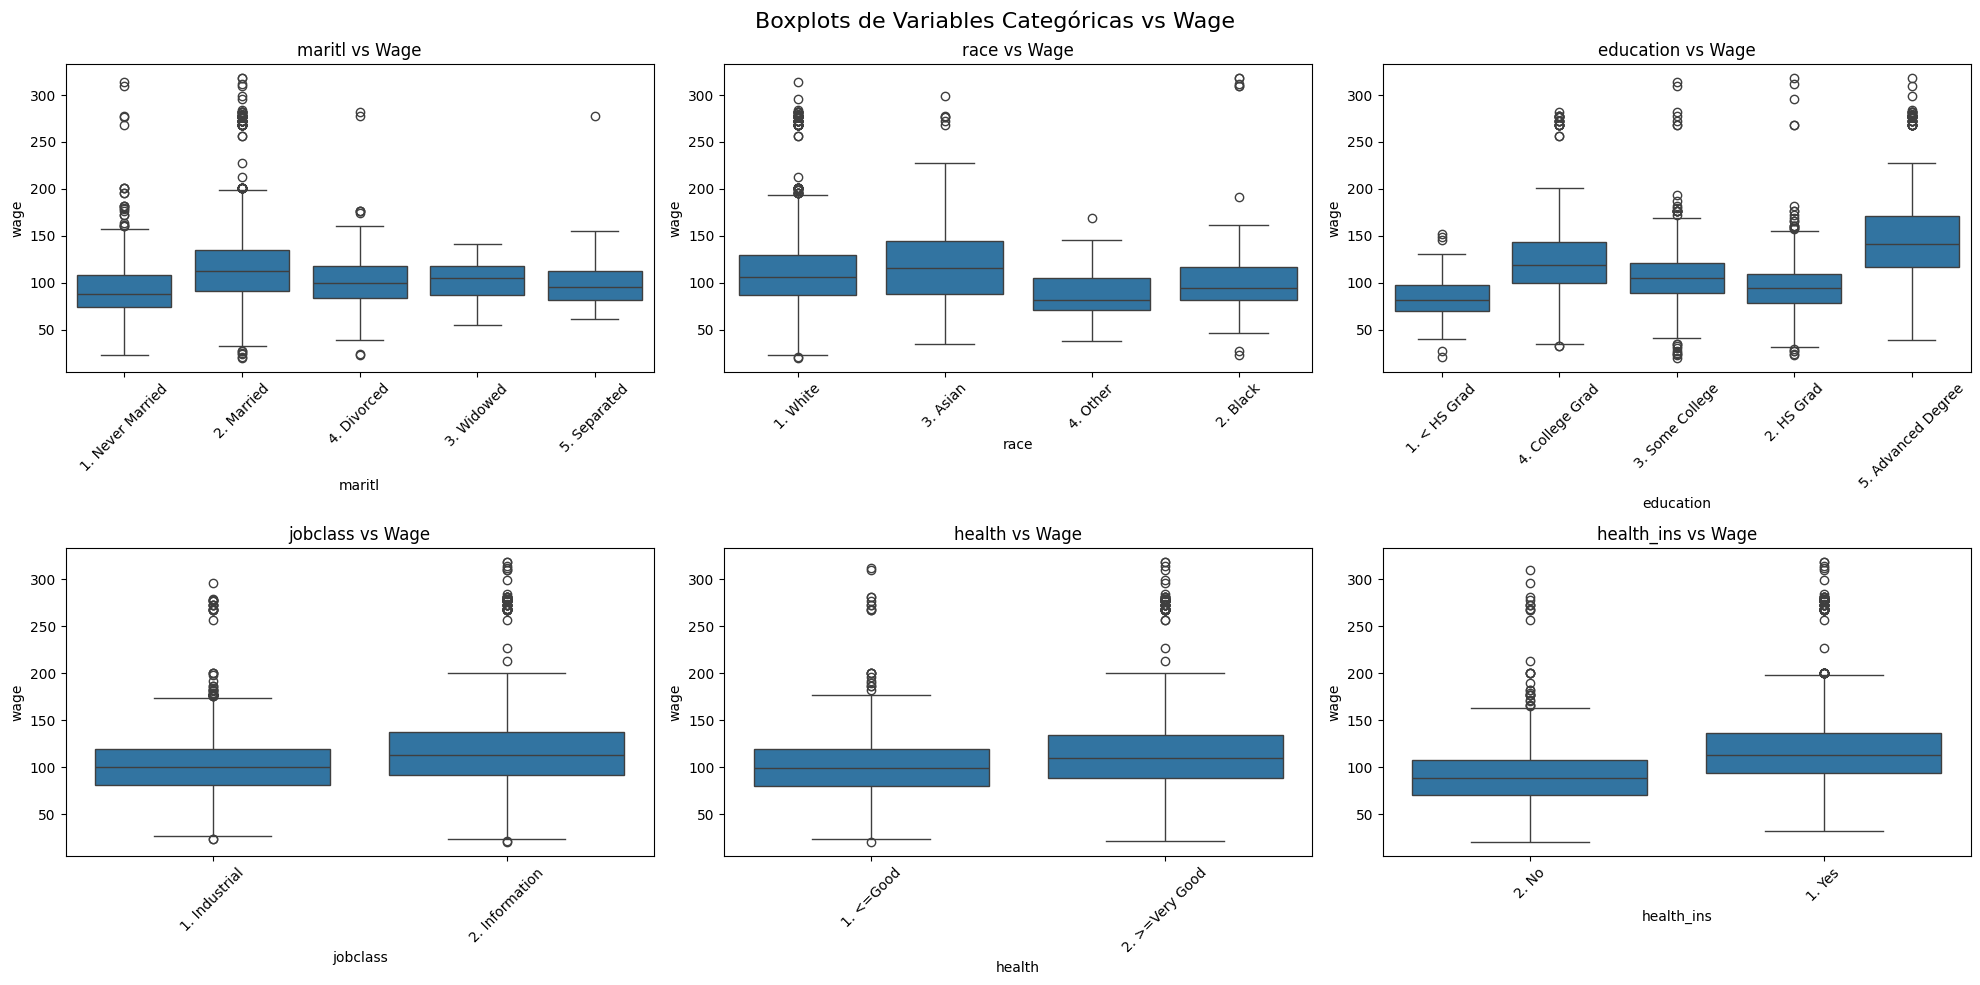

In [ ]:
categorical_vars = ['maritl', 'race', 'education', 'jobclass', 'health', 'health_ins']
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Boxplots de Variables Categóricas vs Wage', fontsize=16)
for i, var in enumerate(categorical_vars):
    row = i // 3
    col = i % 3
    sns.boxplot(x=var, y='wage', data=df, ax=axes[row, col])
    axes[row, col].set_title(f'{var} vs Wage')
    axes[row, col].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [ ]:
clean_cols = ['maritl', 'race', 'education', 'jobclass', 'health', 'health_ins']

for col in clean_cols:
    df[col] = df[col].map(lambda x: x[0]).astype(int)


In [ ]:
#df.drop(['sex', 'region'], axis = 1, inplace = True)
X = df.drop(['logwage', 'wage', 'year'], axis = 1)
y = df['logwage']



[]

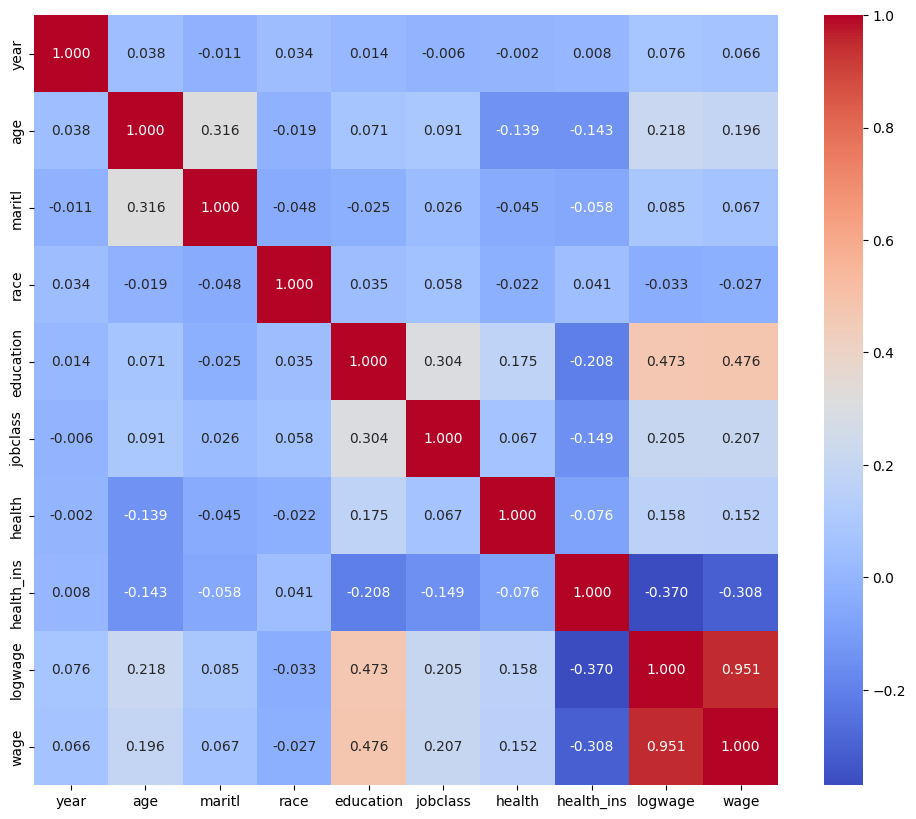

In [ ]:
plt.figure(figsize = (12,10))
sns.heatmap(df.corr(), annot = True, fmt = '3.3f', cmap = 'coolwarm')
plt.plot()

In [ ]:
model = sm.OLS(y, sm.add_constant(X)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                logwage   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     214.4
Date:                Wed, 29 Jan 2025   Prob (F-statistic):          1.29e-258
Time:                        22:58:10   Log-Likelihood:                -512.06
No. Observations:                3000   AIC:                             1040.
Df Residuals:                    2992   BIC:                             1088.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2097      0.042    100.193      0.0

We can see that the most important variables for the model are:

1. Education: The higher is the education of the subject, the higher is their wage. This variable has a huge F-statistic, making it a good indicator.

2. Age: This is also a big one, telling us the older is the person, the higher will be his expirience in the market.

3. health_ins: This tell us that the better the health_ins package the better the job.

4. health

# Using a GAM with interactions

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   age         3000 non-null   int64
 1   maritl      3000 non-null   int64
 2   race        3000 non-null   int64
 3   education   3000 non-null   int64
 4   jobclass    3000 non-null   int64
 5   health      3000 non-null   int64
 6   health_ins  3000 non-null   int64
dtypes: int64(7)
memory usage: 164.2 KB


In [ ]:
X_transformed = dmatrix('cr(age, df=7, constraints="center") + C(race) + C(health) + C(health_ins) + C(education)',
                        data = {'age': df['age'], 'education' : df['education'],
                                'health_ins': df['health_ins'], 'health': df['health'], 'race': df['race']}, return_type='dataframe')

model_glm = sm.OLS(y, sm.add_constant(X_transformed)).fit()

print(model_glm.summary())

                            OLS Regression Results                            
Dep. Variable:                logwage   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     108.2
Date:                Wed, 29 Jan 2025   Prob (F-statistic):          1.15e-281
Time:                        23:21:50   Log-Likelihood:                -435.42
No. Observations:                3000   AIC:                             904.8
Df Residuals:                    2983   BIC:                             1007.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

we were able to upgrade the score from 0.334 to 0.368 in R2.
Was it worth it?
The answer depends on what would you use your model, by adding this glm we are adding much complexity to the model and also adding more variables, which makes the model harder to interpret and with a very small upgrade.